<a href="https://colab.research.google.com/github/CavinAfrane/alpha-centauri-simulations/blob/main/Alphacen_Orbitalmechanics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alpha_cent(Orbital mechanics)

In [ ]:
import rebound
import numpy as np
import csv
import time
import os

# ================= Constants =================
M_A = 1.133       # Alpha Cen A mass (Msun)
L_A = 1.519       # Alpha Cen A luminosity
M_B = 0.972       # Alpha Cen B mass (Msun)
abin = 23.78
ebin = 0.52
omg_bin = np.radians(231.65 + 204.85)
MA_bin = np.radians(209.6901)

M_E = 3.003e-6    # Earth mass (Msun)
R_E = 4.26352e-5  # Earth radius (AU)
R_roche = 2.44 * R_E * (5.5 / 3.3) ** (1./3)

ap = np.sqrt(L_A)  # Planet semi-major axis (AU)
t_scale = 1e4      # Total integration time (yr)
out_step = 0.5      # Output step (yr)
num_particles = 10

# Golden ratio function for mean anomalies
gold_ratio = (1 + np.sqrt(5)) / 2
def get_MA(j):
    return (2 * np.pi * j * gold_ratio) % (2 * np.pi)

# ================= Hill-radius function =================
def hill_radius(M_star, M_planet, a_planet):
    return a_planet * (M_planet / (3 * M_star))**(1/3)

# ================= Simulation Function =================
def run_simulation(m_planet, beta):
    sim = rebound.Simulation()
    sim.integrator = "ias15"
    sim.units = ('AU', 'Msun', 'yr')
    sim.dt = 0.042
    sim.collision = "direct"

    # Add Alpha Cen A
    sim.add(m=M_A)

    # Add planet (current mass)
    sim.add(m=m_planet, a=ap, M=get_MA(1), r=R_E, primary=sim.particles[0])

    # Compute Hill radius for this planet
    R_H = hill_radius(M_A, m_planet, ap)

    # Add multiple test particles spaced by β * Hill radius
    test_particle_hashes = []
    for j in range(num_particles):
        a_tp = ap + beta * R_H
        sim.add(m=0, a=a_tp, M=get_MA(2+j), r=R_E, primary=sim.particles[0], hash=f"tp{j}")
        test_particle_hashes.append(f"tp{j}")

    # Add Alpha Cen B
    sim.add(m=M_B, a=abin, e=ebin, omega=omg_bin, M=MA_bin)
    sim.move_to_com()

    # Dictionary to store lifetimes
    lifetime_dict = {h: None for h in test_particle_hashes}
    t = 0.0
    while t < t_scale:
        try:
            sim.integrate(t)
        except rebound.Collision:
            for h in test_particle_hashes:
                if lifetime_dict[h] is None:
                    try:
                        p = sim.particles[h]
                        if p.d > 8 or p.d < 0.1:
                            lifetime_dict[h] = sim.t
                            sim.remove(hash=h)
                        else:
                            d_tp = np.sqrt((p.x - sim.particles[1].x)**2 +
                                           (p.y - sim.particles[1].y)**2 +
                                           (p.z - sim.particles[1].z)**2)
                            if d_tp < R_roche:
                                lifetime_dict[h] = sim.t
                                sim.remove(hash=h)
                    except rebound.ParticleNotFound:
                        continue
            t += out_step
            continue

        for h in test_particle_hashes:
            if lifetime_dict[h] is None:
                try:
                    p = sim.particles[h]
                    if p.d > 8 or p.d < 0.1:
                        lifetime_dict[h] = sim.t
                        sim.remove(hash=h)
                    else:
                        d_tp = np.sqrt((p.x - sim.particles[1].x)**2 +
                                       (p.y - sim.particles[1].y)**2 +
                                       (p.z - sim.particles[1].z)**2)
                        if d_tp < R_roche:
                            lifetime_dict[h] = sim.t
                            sim.remove(hash=h)
                except rebound.ParticleNotFound:
                    continue

        if all(v is not None for v in lifetime_dict.values()):
            break

        t += out_step

    # Fill in lifetimes for surviving particles
    for h in test_particle_hashes:
        if lifetime_dict[h] is None:
            lifetime_dict[h] = sim.t

    # Compute log10 lifetimes and period ratios
    log_times = [np.log10(lifetime_dict[h]) for h in test_particle_hashes]
    P_planet = np.sqrt(ap**3 / M_A)
    P_particles = np.sqrt(np.array([ap + beta * R_H]*num_particles)**3 / M_A)
    period_ratios = P_particles / P_planet

    return log_times, period_ratios.tolist()

# ================= Main Loop =================
output_file = "/content/drive/MyDrive/clearing_zone_saturn_variations.csv"
output_dir = os.path.dirname(output_file)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

with open(output_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "planet_mass_EarthMass", "beta", "test_particle_index",
        "a_tp_AU", "period_ratio", "lifetime_yr", "log10_lifetime", "wall_time_s"
    ])

    # ======= Planet mass variations in Earth-mass units =======
    planet_mass_factors = [100, 200, 300]   # in Earth masses

    beta_min = 2
    beta_max = 30
    beta_step = 0.5
    beta_values = np.arange(beta_min, beta_max + beta_step, beta_step)

    for m_factor in planet_mass_factors:
        m_planet = m_factor * M_E    # now directly in Earth masses
        R_H = hill_radius(M_A, m_planet, ap)

        for beta in beta_values:
            start_time = time.time()
            log_lifetimes, period_ratios = run_simulation(m_planet, beta)
            end_time = time.time()
            wall_time = end_time - start_time

            for idx in range(num_particles):
                a_tp = ap + beta * R_H
                lifetime = 10**log_lifetimes[idx]
                pr = period_ratios[idx]

                writer.writerow([
                    m_planet / M_E, beta, idx, a_tp, pr, lifetime,
                    log_lifetimes[idx], wall_time
                ])

                print(f"Planet = {m_factor:.1f} M_Earth, beta={beta:.2f}, tp{idx} → "
                      f"lifetime={lifetime:.2f} yr, period ratio={pr:.3f}, "
                      f"wall_time={wall_time:.1f}s")

print(f"Results saved to {output_file}")


Planet = 100.0 M_Earth, beta=2.00, tp0 → lifetime=5981.79 yr, period ratio=1.137, wall_time=12.5s
Planet = 100.0 M_Earth, beta=2.00, tp1 → lifetime=2.64 yr, period ratio=1.137, wall_time=12.5s
Planet = 100.0 M_Earth, beta=2.00, tp2 → lifetime=204.95 yr, period ratio=1.137, wall_time=12.5s
Planet = 100.0 M_Earth, beta=2.00, tp3 → lifetime=563.47 yr, period ratio=1.137, wall_time=12.5s
Planet = 100.0 M_Earth, beta=2.00, tp4 → lifetime=1.07 yr, period ratio=1.137, wall_time=12.5s
Planet = 100.0 M_Earth, beta=2.00, tp5 → lifetime=6167.50 yr, period ratio=1.137, wall_time=12.5s
Planet = 100.0 M_Earth, beta=2.00, tp6 → lifetime=5403.50 yr, period ratio=1.137, wall_time=12.5s
Planet = 100.0 M_Earth, beta=2.00, tp7 → lifetime=87.52 yr, period ratio=1.137, wall_time=12.5s
Planet = 100.0 M_Earth, beta=2.00, tp8 → lifetime=2352.50 yr, period ratio=1.137, wall_time=12.5s
Planet = 100.0 M_Earth, beta=2.00, tp9 → lifetime=9110.50 yr, period ratio=1.137, wall_time=12.5s
Planet = 100.0 M_Earth, beta=2

# Mean_Plots

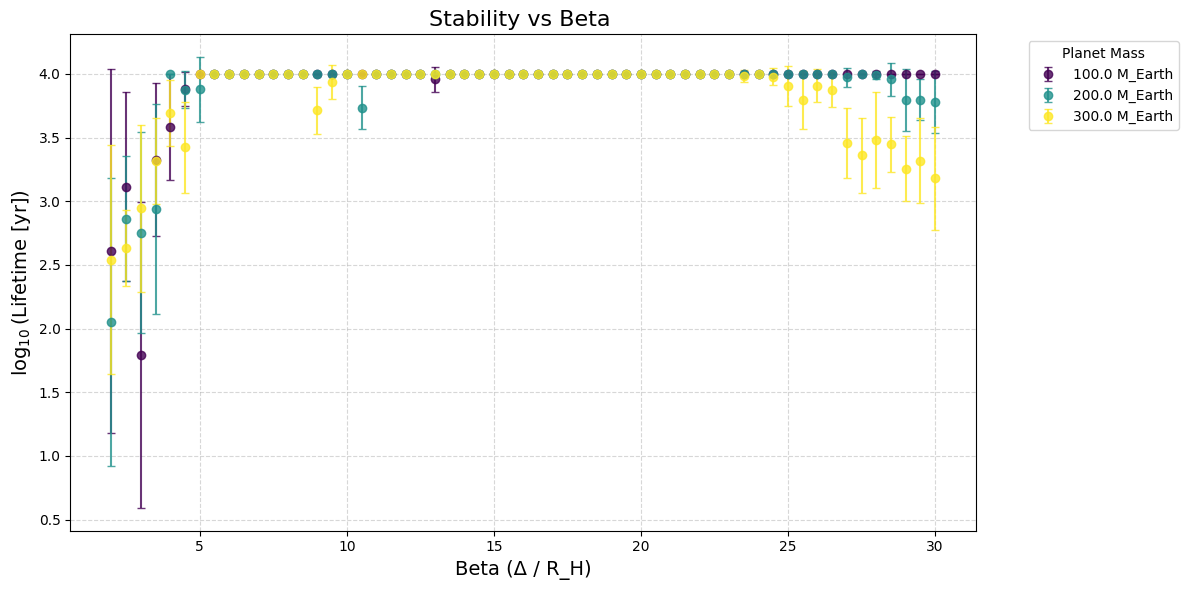

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ================= Load CSV =================
csv_file = "/content/drive/MyDrive/clearing_zone_saturn_variations.csv"
df = pd.read_csv(csv_file)

# ================= Compute mean and std for each (beta, mass) =================
grouped = df.groupby(['beta', 'planet_mass_EarthMass'])['log10_lifetime'].agg(['mean', 'std']).reset_index()

# ================= Plot with error bars =================
plt.figure(figsize=(12,6))

mass_factors = sorted(grouped['planet_mass_EarthMass'].unique())
colors = plt.cm.viridis(np.linspace(0,1,len(mass_factors)))

for i, m in enumerate(mass_factors):
    subset = grouped[grouped['planet_mass_EarthMass'] == m]
    plt.errorbar(
        subset['beta'],
        subset['mean'],
        yerr=subset['std'],
        fmt='o',
        color=colors[i],
        label=f'{m:.1f} M_Earth',
        capsize=3,
        alpha=0.8
    )

plt.xlabel('Beta (Δ / R_H)', fontsize=14)
plt.ylabel(r'$\log_{10}(\mathrm{Lifetime\ [yr]})$', fontsize=14)
plt.title('Stability vs Beta ', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Planet Mass', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
plt.savefig('plot_error bar')

# B_Max

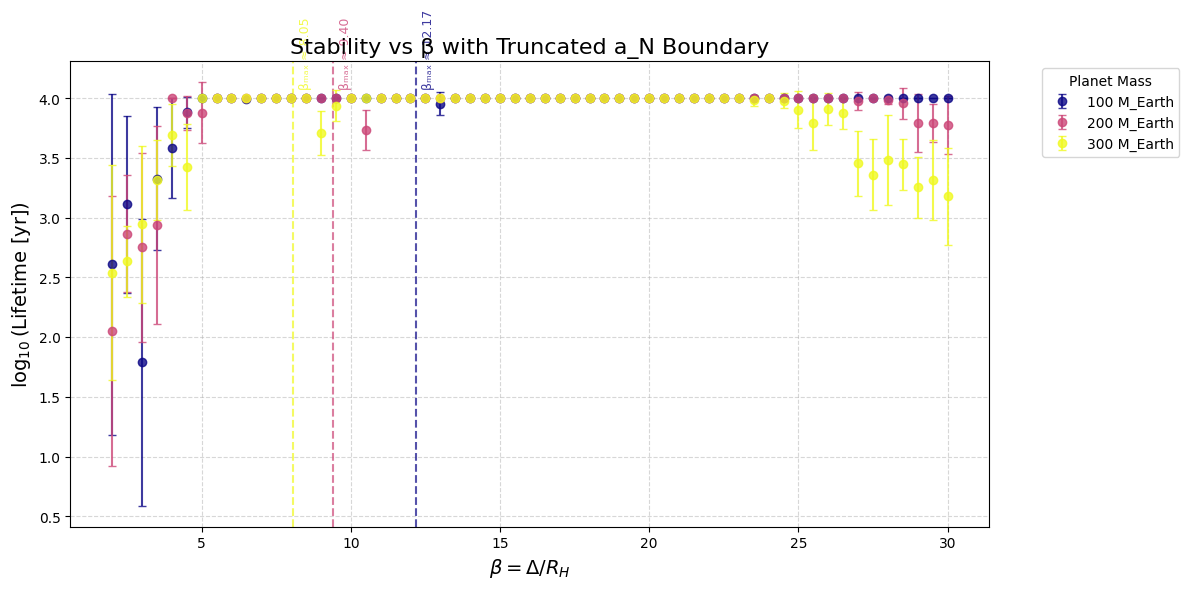

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ================= Load CSV =================
csv_file = "/content/drive/MyDrive/clearing_zone_saturn_variations.csv"
df = pd.read_csv(csv_file)

# ================= Constants =================
M_star = 1.133          # Alpha Cen A mass (Msun)
L_star = 1.519          # Alpha Cen A luminosity
a_bin = 23.78           # Binary semimajor axis (AU)
trunc_frac = 0.115      # Truncation factor
a_trunc = trunc_frac * a_bin
a_p = np.sqrt(L_star)   # Planet semimajor axis (AU)
M_earth = 3.003e-6      # Earth mass (Msun)

# Beta sampling limits (same as simulation)
beta_min = 2.0
beta_max_raw = 30.0

# ================= Hill Radius Function =================
def hill_radius(M_star, M_planet, a_planet):
    return a_planet * (M_planet / (3.0 * M_star))**(1.0/3.0)

# ================= Beta_max Function (with truncation) =================
def compute_beta_max(M_planet):
    R_H = hill_radius(M_star, M_planet, a_p)
    a1_raw = a_p + beta_min * R_H
    aN_raw = a_p + beta_max_raw * R_H
    a1 = a1_raw
    aN = min(aN_raw, a_trunc)  # Apply truncation limit
    ratio_term = (aN - a1) / (aN + a1)
    return ratio_term * (12.0 * (M_star / M_planet))**(1.0/3.0)

# ================= Compute mean and std for each (beta, mass) =================
grouped = df.groupby(['beta', 'planet_mass_EarthMass'])['log10_lifetime'].agg(['mean', 'std']).reset_index()

# ================= Plot =================
plt.figure(figsize=(12,6))
mass_factors = sorted(grouped['planet_mass_EarthMass'].unique())
colors = plt.cm.plasma(np.linspace(0,1,len(mass_factors)))

for i, m_earth in enumerate(mass_factors):
    subset = grouped[grouped['planet_mass_EarthMass'] == m_earth]
    plt.errorbar(
        subset['beta'],
        subset['mean'],
        yerr=subset['std'],
        fmt='o',
        color=colors[i],
        label=f'{m_earth:.0f} M_Earth',
        capsize=3,
        alpha=0.8
    )

    # ---- Compute and plot β_max line ----
    M_planet = m_earth * M_earth
    beta_max_val = compute_beta_max(M_planet)
    plt.axvline(beta_max_val, color=colors[i], linestyle='--', alpha=0.7)

    # Optional label for β_max
    plt.text(beta_max_val + 0.2, max(subset['mean']) + 0.1,
             f'βₘₐₓ ≈ {beta_max_val:.2f}',
             rotation=90, color=colors[i], fontsize=9, alpha=0.8)

# ================= Labels and Style =================
plt.xlabel(r'$\beta = \Delta / R_H$', fontsize=14)
plt.ylabel(r'$\log_{10}(\mathrm{Lifetime\ [yr]})$', fontsize=14)
plt.title('Stability vs β with Truncated a_N Boundary', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Planet Mass', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# ================= Save & Show =================
plt.savefig('/content/drive/MyDrive/stability_vs_beta_truncation.png', dpi=300)
plt.show()


# Trend_points

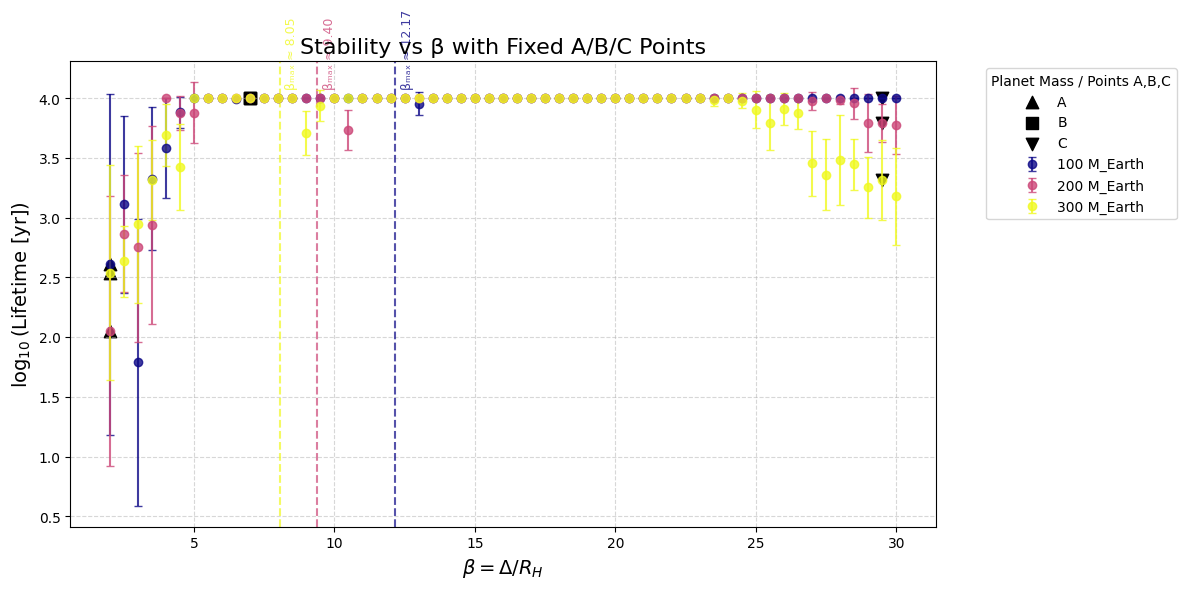

In [ ]:
# ================= Plot with fixed A, B, C beta values =================
plt.figure(figsize=(12,6))
colors = plt.cm.plasma(np.linspace(0,1,len(mass_factors)))

# Fixed beta points for each mass
abc_trend_values = {
    100.0: {'A': 2.0, 'B': 7.0, 'C': 29.5},
    200.0: {'A': 2.0, 'B': 7.0, 'C': 29.5},
    300.0: {'A': 2.0, 'B': 7.0, 'C': 29.5}
}

for i, m_earth in enumerate(mass_factors):
    subset = grouped[grouped['planet_mass_EarthMass'] == m_earth]
    beta_vals = subset['beta'].values
    lifetime_vals = subset['mean'].values

    # ---- Find closest indices for fixed A/B/C beta values ----
    A_idx = (np.abs(beta_vals - abc_trend_values[m_earth]['A'])).argmin()
    B_idx = (np.abs(beta_vals - abc_trend_values[m_earth]['B'])).argmin()
    C_idx = (np.abs(beta_vals - abc_trend_values[m_earth]['C'])).argmin()

    # Plot mean lifetime with error bars
    plt.errorbar(
        beta_vals,
        lifetime_vals,
        yerr=subset['std'].values,
        fmt='o',
        color=colors[i],
        label=f'{m_earth:.0f} M_Earth',
        capsize=3,
        alpha=0.8
    )

    # β_max line (optional)
    M_planet = m_earth * M_earth
    beta_max_val = compute_beta_max(M_planet)
    plt.axvline(beta_max_val, color=colors[i], linestyle='--', alpha=0.7)
    plt.text(beta_max_val + 0.2, max(lifetime_vals)+0.1,
             f'βₘₐₓ ≈ {beta_max_val:.2f}', rotation=90, color=colors[i], fontsize=9, alpha=0.8)

    # ---- Plot fixed points A, B, C ----
    plt.scatter(beta_vals[A_idx], lifetime_vals[A_idx], color='k', s=80, marker='^', label='A' if i==0 else "")
    plt.scatter(beta_vals[B_idx], lifetime_vals[B_idx], color='k', s=80, marker='s', label='B' if i==0 else "")
    plt.scatter(beta_vals[C_idx], lifetime_vals[C_idx], color='k', s=80, marker='v', label='C' if i==0 else "")

# Labels and style
plt.xlabel(r'$\beta = \Delta / R_H$', fontsize=14)
plt.ylabel(r'$\log_{10}(\mathrm{Lifetime\ [yr]})$', fontsize=14)
plt.title('Stability vs β with Fixed A/B/C Points', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Planet Mass / Points A,B,C', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


# New Section

# New Section